## Creating word2vec for dialoge clustering

In [1]:
import pandas as pd
import numpy as np

In [2]:
## read data
df = pd.read_csv('./data/part1-2-3.csv')
df.columns

Index(['speaker_order', '更正order', 'content', '人工更正', '对象', '态度', '行为'], dtype='object')

In [3]:
## remove Nan in 人工更正
df = df.dropna(subset=['人工更正'])

In [4]:
dialoge = df['人工更正']
dialoge_label = df['更正order']

In [5]:
dialoge_label.value_counts()

9.0     565
8.0     497
1.0     458
12.0    391
4.0     388
11.0    376
7.0     337
10.0    238
3.0     210
5.0     208
6.0     149
2.0     136
Name: 更正order, dtype: int64

In [6]:
df.shape

(3953, 7)

## 1. trainning word2vec

### using jieba to create word segments

In [7]:
from utils import generate_seglist, remove_punctuation

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.736 seconds.
Prefix dict has been built succesfully.


### stop-words

In [8]:
stopwords = {}.fromkeys([ word.rstrip() for word in pd.read_csv('./data/stopwords.txt',header=None)[0].values ])

### word segment

In [9]:
sentence_seg = dialoge.apply(lambda x: generate_seglist(x,stopwords))

In [10]:
sentence_seg.tail()

3950            [狼, 查杀, 狼]
3951                  [我服]
3952                  [我服]
3953    [视角, 里, 两张牌, 1, 6]
3954                    []
Name: 人工更正, dtype: object

### trainning

In [11]:
from word2vec.train_word2vec import generate_word2vec

In [12]:
model = generate_word2vec(sentence_seg,'./data/word2vec_wolf.model','./data/word2vec_wolf.vector')

In [42]:
result = model.most_similar(u'狼人')

In [43]:
for word in result:
    print(word[0],word[1])

一张 0.9969810843467712
7 0.9969286322593689
9 0.9968434572219849
12 0.9968425035476685
狼 0.9968361854553223
牌 0.9968193769454956
  0.9967952966690063
4 0.9967641830444336
位 0.9967229962348938
警徽 0.9966402053833008


## 2. generate word2vec

In [15]:
from utils import generate_sentence_vec

In [16]:
sentence_word2vec = sentence_seg.apply(lambda x:generate_sentence_vec(x, model, num_features=400))
sentence_word2vec = pd.DataFrame(sentence_word2vec.tolist())

In [17]:
sentence_word2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-0.000382,-0.003143,0.014360,0.003560,0.001146,0.016539,-0.006242,-0.009717,0.002565,0.013287,...,0.003087,0.007151,-0.008839,-0.000484,-0.020017,0.008113,-0.003059,0.008081,-0.006103,-0.009135
1,-0.000713,-0.006324,0.030301,0.009010,0.005565,0.034504,-0.011347,-0.017893,0.002361,0.027018,...,0.009325,0.016058,-0.018944,-0.003481,-0.042467,0.019352,-0.007014,0.019449,-0.011015,-0.018496
2,-0.000751,-0.004029,0.016096,0.004584,0.003395,0.018421,-0.005866,-0.009962,0.001234,0.015285,...,0.004884,0.008271,-0.010429,-0.001827,-0.023146,0.010373,-0.004210,0.011341,-0.006671,-0.009801
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.000871,-0.000103,0.004457,0.002524,0.000728,0.004508,-0.001114,-0.003064,0.001052,0.003285,...,0.000812,0.002864,-0.003187,-0.001034,-0.006157,0.002403,-0.000483,0.003229,-0.000641,-0.003304


In [18]:
sentence_word2vec = sentence_word2vec.values
sentence_word2vec

array([[-0.00038195, -0.00314335,  0.01435995, ...,  0.00808078,
        -0.00610261, -0.00913508],
       [-0.00071327, -0.0063244 ,  0.03030065, ...,  0.0194491 ,
        -0.01101461, -0.01849557],
       [-0.00075143, -0.00402934,  0.01609648, ...,  0.01134066,
        -0.00667086, -0.00980081],
       ..., 
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [-0.00095948, -0.00570738,  0.0245945 , ...,  0.01628431,
        -0.00956113, -0.01647014],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

## 3. kmeans clustering

In [19]:
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# load dataset
X = sentence_word2vec[~np.isnan(sentence_word2vec).any(axis=1)]
y = dialoge_label[~np.isnan(sentence_word2vec).any(axis=1)]

##### cluster data into K=1..10 clusters #####
K = range(1,15)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K]
centroids = [cent for (cent,var) in KM]   # cluster centroids

# alternative: scipy.spatial.distance.cdist
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

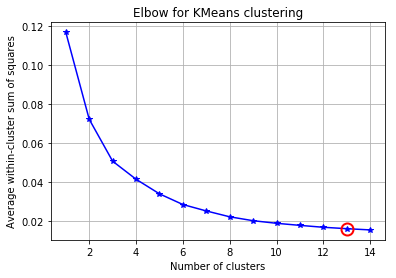

In [21]:
##### plot ###
kIdx = 12

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
    markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

## 4. tsne

In [22]:
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

/usr/local/envs/deeplearning/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


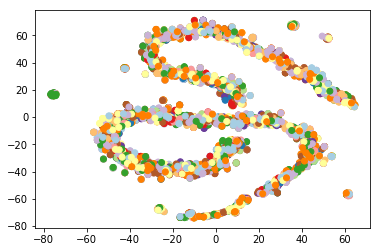

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='Paired')
ax.legend()
plt.show()

In [35]:
np.where(X_tsne[:,1]<-70)

(array([ 171,  189,  318,  420,  754,  847,  914,  917,  937, 1007, 1059,
        1066, 1070, 1075, 1188, 1190, 1204, 1212, 1244, 1255, 1268, 1362,
        1367, 1384, 1405, 1421, 1544, 1607, 1623, 1728, 1762, 1791, 2046,
        2063, 2124, 2127, 2167, 2169, 2172, 2173, 2177, 2212, 2215, 2284,
        2317, 2340, 2355, 2361, 2386, 2391, 2392, 2394, 2428, 2452, 2505,
        2546, 2552, 2554, 2597, 2619, 2637, 2700, 2704, 2725, 2732, 2765,
        2774, 2783, 2797, 2798, 2836, 2837, 2877, 2883, 2884, 2900, 2938,
        2945, 2947, 2991, 3026, 3069, 3076, 3137, 3138, 3140, 3219, 3236,
        3237, 3293, 3296, 3332, 3365, 3373, 3429]),)

In [36]:
X[np.where(X_tsne[:,1]<-70)]

array([[-0.00167031, -0.01348056,  0.05503345, ...,  0.03676451,
        -0.01982247, -0.03713398],
       [-0.00167031, -0.01348056,  0.05503345, ...,  0.03676451,
        -0.01982247, -0.03713398],
       [-0.00117272, -0.01238479,  0.05189994, ...,  0.03280076,
        -0.01840513, -0.03422448],
       ..., 
       [-0.00141957, -0.01256491,  0.05565215, ...,  0.03712355,
        -0.02034513, -0.03708953],
       [-0.00167031, -0.01348056,  0.05503345, ...,  0.03676451,
        -0.01982247, -0.03713398],
       [-0.00117272, -0.01238479,  0.05189994, ...,  0.03280076,
        -0.01840513, -0.03422448]])

In [37]:
np.where((sentence_word2vec == X[171]).all(axis=1))

(array([ 207,  227, 1423, 1612, 2531, 2749, 3533, 3703, 3885]),)

In [38]:
sentence_seg[207]

['12']

In [39]:
sentence_seg[227]

['12']

In [40]:
sentence_seg[1612]

['狼', '人牌']

In [41]:
sentence_seg[2749]

['轮次']